## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-10-07 23:18:28.993355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
XVIEW_RECOGNITION_PATH = "./data/xview_recognition/"

In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(f'{XVIEW_RECOGNITION_PATH}/{filename}', 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:
## Hyperparameters
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.1
REGULARIZER_PENALTY = 1e-5
EPOCHS = 50

In [7]:
import json

# Load database
json_file = f'{XVIEW_RECOGNITION_PATH}/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [10]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2

print('Load model')

model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(LayerNormalization())
# Dense block 1
model.add(Dense(1024, activation='gelu', kernel_regularizer=l2(REGULARIZER_PENALTY))) # Dense layers were originally x2 neurons
model.add(LayerNormalization())
model.add(Dropout(DROPOUT_RATE))
# Dense block 2
model.add(Dense(512, activation='gelu', kernel_regularizer=l2(REGULARIZER_PENALTY)))
model.add(LayerNormalization())
model.add(Dropout(DROPOUT_RATE))
# Dense block 3
model.add(Dense(256, activation='gelu', kernel_regularizer=l2(REGULARIZER_PENALTY)))
model.add(LayerNormalization())
model.add(Dropout(DROPOUT_RATE))
# Dense block 4
model.add(Dense(128, activation='gelu', kernel_regularizer=l2(REGULARIZER_PENALTY)))
model.add(LayerNormalization())
model.add(Dropout(DROPOUT_RATE))
# Output layer
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Load model


/home/yeray/visioncomp/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1759871915.178004     745 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 150528)         │       301,056 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 1024)           │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 512)            │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,137,293 (591.80 MB)

 Trainable params: 155,137,293 (591.80 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.optimizers import AdamW

opt = AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
#early_stop = EarlyStopping('val_loss', patience=10, verbose=1, restore_best_weights=True)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, terminate]

In [13]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [14]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

In [15]:
import math
import numpy as np

print('Training model')
train_steps = math.ceil(len(objs_train) / BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid) / BATCH_SIZE)

h = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Best validation model (using validation loss)
best_idx = int(np.argmin(h.history['val_loss']))
best_values = h.history['val_accuracy'][best_idx], h.history['val_loss'][best_idx]
print(
    f'''--------\n
    Best validation model
    - epoch: {str(best_idx + 1)}
    - val_acc: {str(best_values[0])}
    - val_loss: {str(best_values[1])}'''
)

Training model
Epoch 1/50


2025-10-07 23:19:16.008160: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f22780037e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-07 23:19:16.008238: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-10-07 23:19:16.111053: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-07 23:19:16.637069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-07 23:19:19.362510: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2103', 9476 bytes spill stores, 9844 bytes spill loads

2025-10-07 23:19:19.621445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation

65/66 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - accuracy: 0.2454 - loss: 2.4122 

2025-10-07 23:29:11.244760: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1819', 12 bytes spill stores, 12 bytes spill loads

2025-10-07 23:29:11.524065: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2103', 12 bytes spill stores, 12 bytes spill loads

2025-10-07 23:29:11.842721: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1819', 60 bytes spill stores, 60 bytes spill loads

2025-10-07 23:29:11.846209: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2401', 60 bytes spill stores, 60 bytes spill loads

2025-10-07 23:29:11.900969: I external/l

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2462 - loss: 2.4087

2025-10-07 23:30:31.894822: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183', 12 bytes spill stores, 12 bytes spill loads

2025-10-07 23:30:31.933941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_329', 12 bytes spill stores, 12 bytes spill loads

2025-10-07 23:30:32.260908: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_329', 60 bytes spill stores, 60 bytes spill loads

2025-10-07 23:30:32.292220: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_183', 60 bytes spill stores, 60 bytes spill loads

2025-10-07 23:30:32.668710: I external/local


Epoch 1: val_loss improved from None to 1.88343, saving model to model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 697s 10s/step - accuracy: 0.2958 - loss: 2.1794 - val_accuracy: 0.3845 - val_loss: 1.8834 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3754 - loss: 1.8996
Epoch 2: val_loss improved from 1.88343 to 1.73715, saving model to model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 555s 9s/step - accuracy: 0.3947 - loss: 1.8527 - val_accuracy: 0.4347 - val_loss: 1.7371 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4365 - loss: 1.7159
Epoch 3: val_loss improved from 1.73715 to 1.63069, saving model to model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 379s 6s/step - accuracy: 0.4471 - loss: 1.6953 - val_accuracy: 0.4720 - val_loss: 1.6307 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4927 - loss: 1.5636
Epoch 4: val_loss improved from 1.63069 to 1.56009, saving model to model.keras
66/66 ━━━━━━

#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [17]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

2025-10-08 04:27:29.346837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads



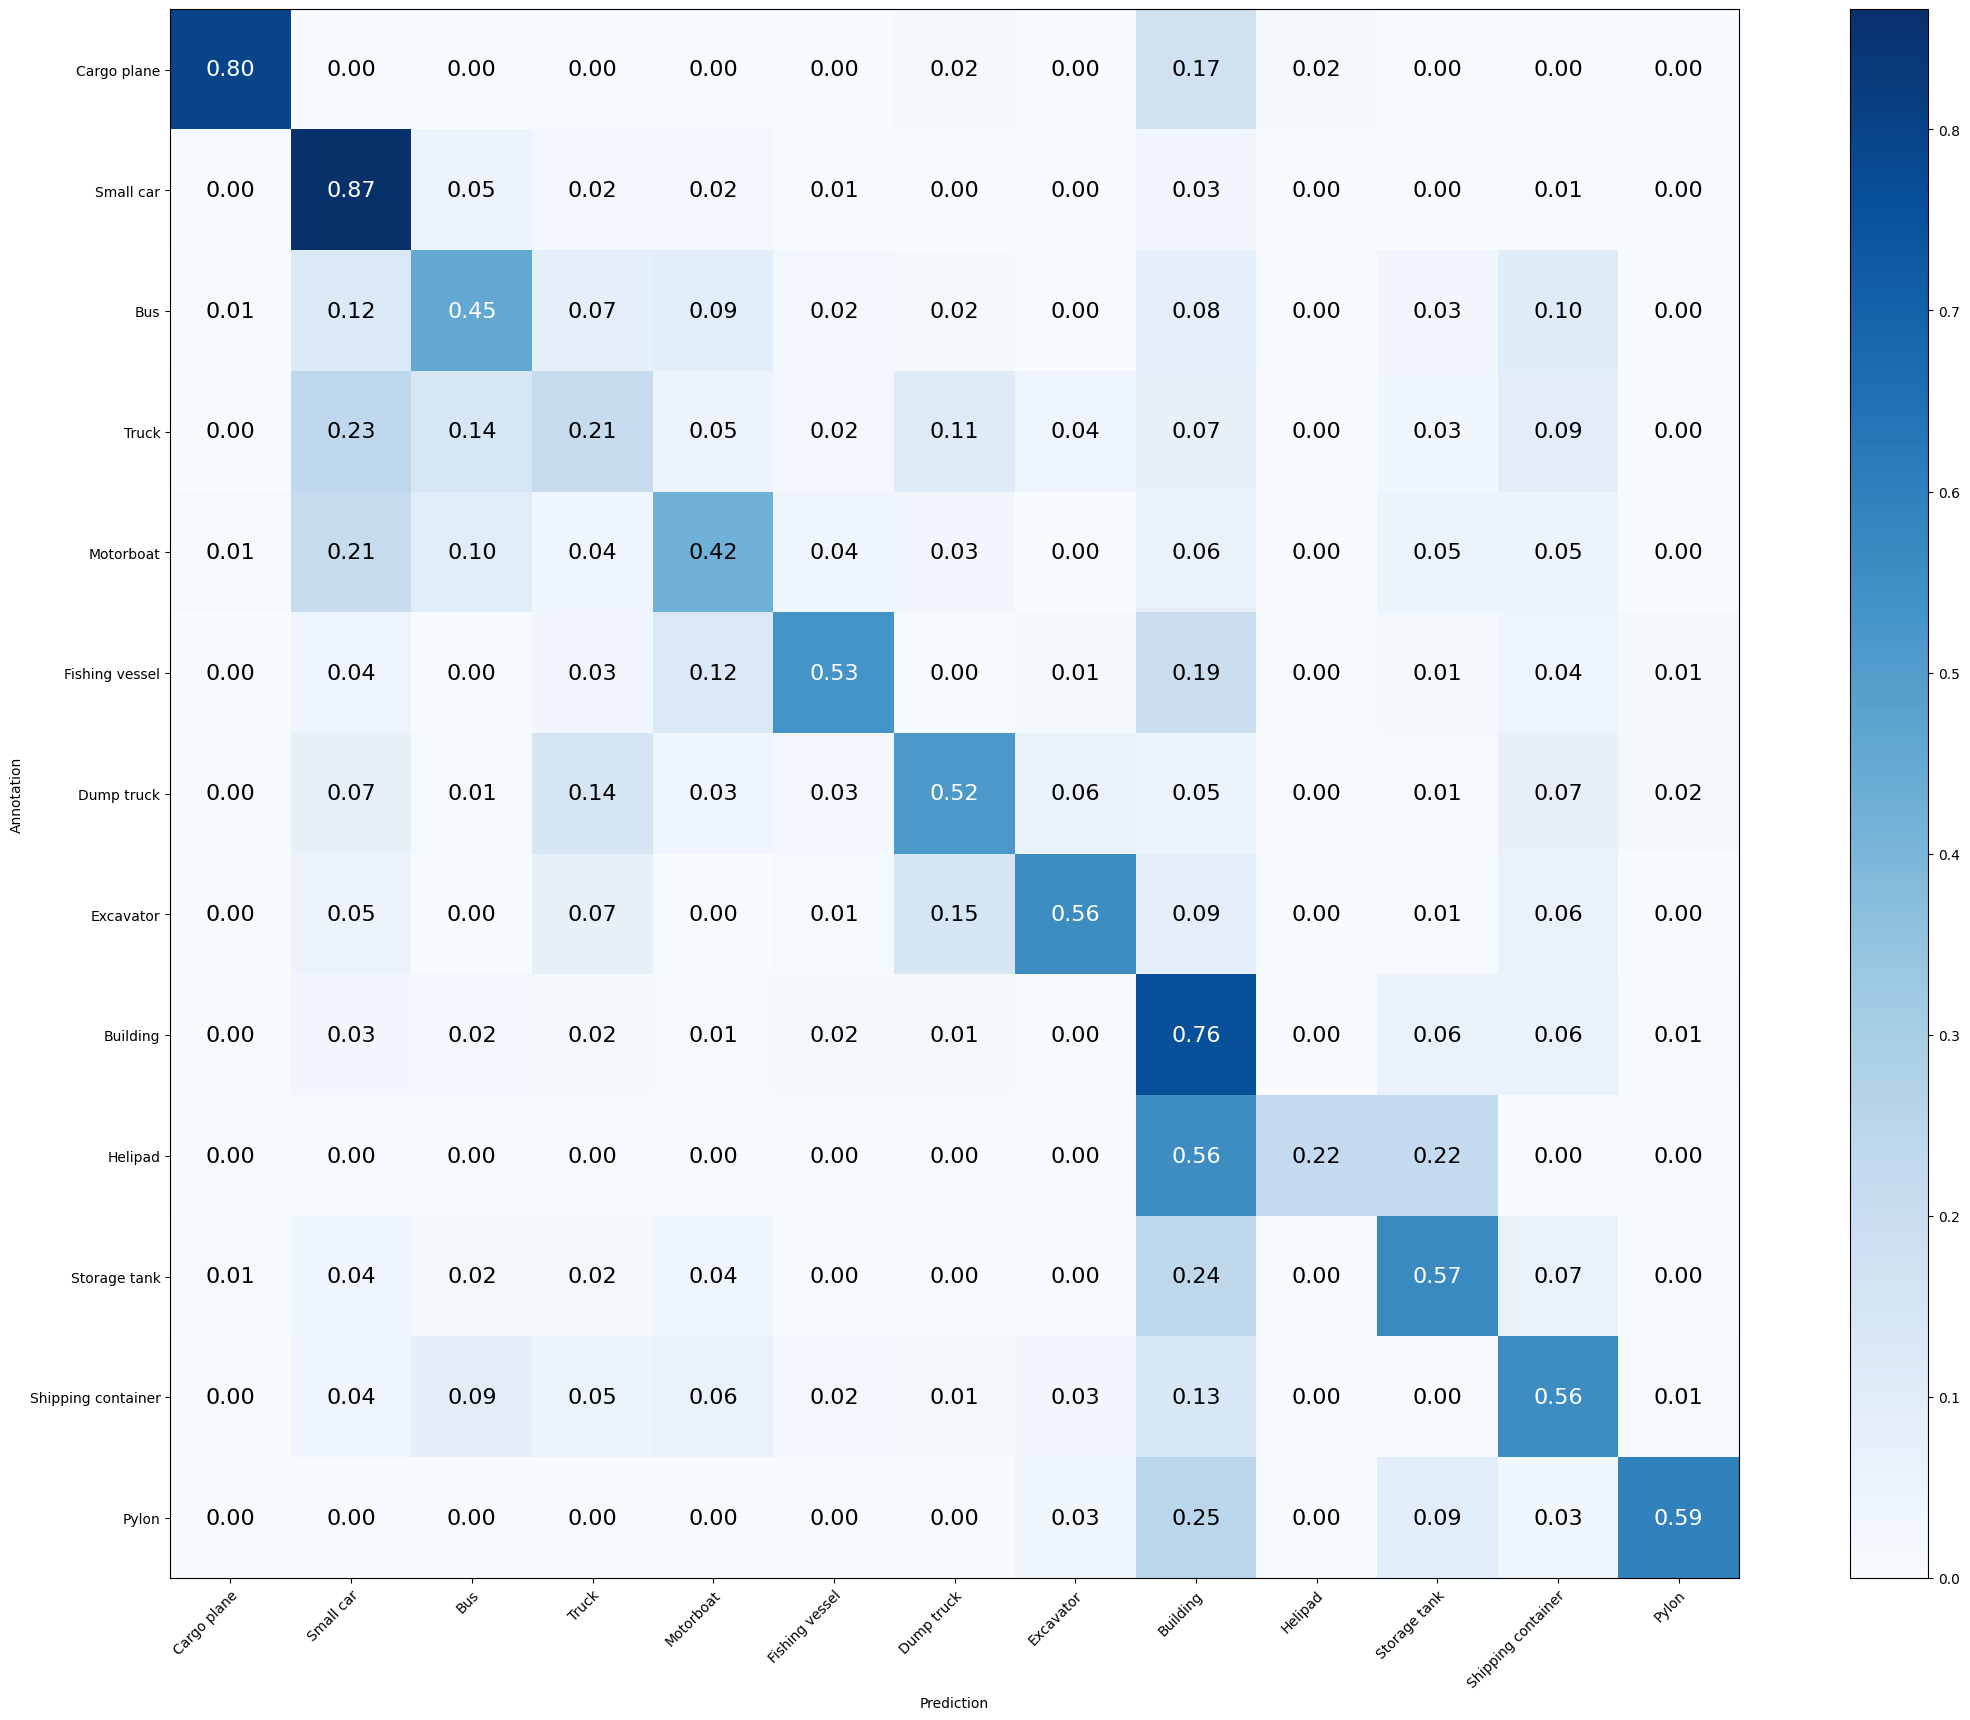

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 59.253%
Mean Recall: 54.269%
Mean Precision: 60.263%
> Cargo plane: Recall: 79.661% Precision: 90.385% Specificity: 99.725% Dice: 84.685%
> Small car: Recall: 86.626% Precision: 67.696% Specificity: 91.203% Dice: 76.000%
> Bus: Recall: 45.402% Precision: 48.171% Specificity: 95.003% Dice: 46.746%
> Truck: Recall: 21.162% Precision: 43.590% Specificity: 95.961% Dice: 28.492%
> Motorboat: Recall: 42.202% Precision: 41.071% Specificity: 96.263% Dice: 41.629%
> Fishing vessel: Recall: 53.425% Precision: 56.522% Specificity: 98.335% Dice: 54.930%
> Dump truck: Recall: 51.695% Precision: 53.982% Specificity: 97.040% Dice: 52.814%
> Excavator: Recall: 55.556% Precision: 66.176% Specificity: 98.718% Dice: 60.403%
> Building: Recall: 76.033% Precision: 64.637% Specificity: 90.013% Dice: 69.873%
> Helipad: Recall: 22.222% Precision: 66.667% Specificity: 99.946% Dice: 33.333%
> Storage tank: Recall: 56.579% Precision: 64.662% Specificity: 97.272% Dice: 60.351%
> Shipping container:

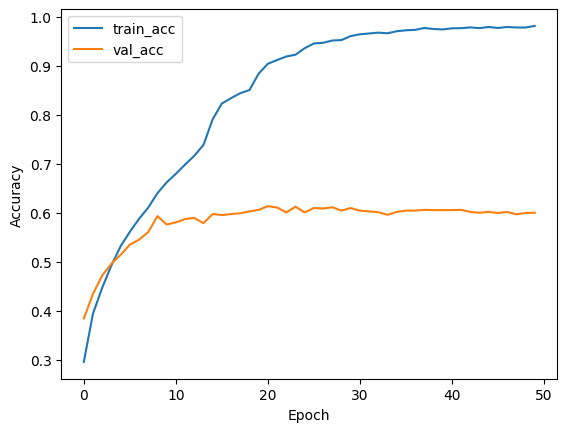

In [20]:
plt.plot(h.history['accuracy'], label='train_acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

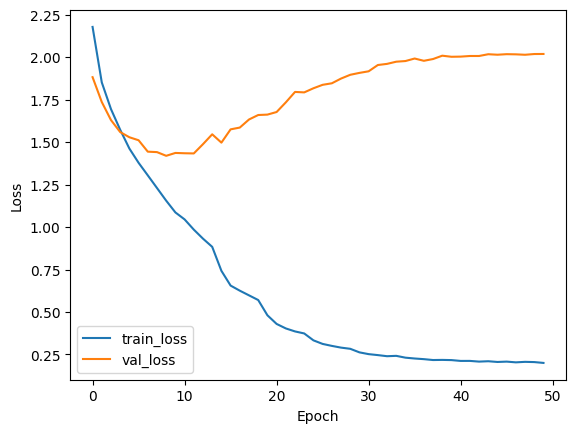

In [21]:
plt.plot(h.history['loss'], label='train_loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the competition.

In [22]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk(f'{XVIEW_RECOGNITION_PATH}/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[26:] + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [23]:
anns[0].filename

'xview_test/Building/0003d089-bc08-457e-9341-a3b6a16b0da4.tif'

In [24]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [25]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)